# Reporting Module Alternative - Jupyter Notebooks

### Alex Spatchek & Adam Forestier
**Last Updated** - August 23, 2024

### Problem Statement
Our Client wants summary statistics and charts about their manufacturing data. They are particularly interested in the column "DefectStatus" which indicates whether the produced batch has a high or low level of defective units.

In addition to the charts and stats, we have trained machine learning algorithms to detect whether or not a batch will have a high number of defective units produced. This will allow the client to tweak inputs in order to receive the desired result - a low amount of defective units. They are able to test changes to production, maintenance hours, etc.; without taking any risk on the plant floor.


In [2]:
import lightgbm as lgb # ML Algorithm
import matplotlib.pyplot as plt # charting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns # charting
import warnings
from joblib import dump # Ability to save model
from imblearn.over_sampling import SMOTE # Balancing imbalanced dataset
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier) # ML Algorithms
from sklearn.feature_selection import (SelectKBest) # Feature selection
from sklearn.linear_model import (ElasticNet, LogisticRegression) # ML Algorithms
from sklearn.metrics import accuracy_score # algorithm scoring
from sklearn.model_selection import (GridSearchCV, train_test_split) # Algorithm training and fine-tuning
from sklearn.preprocessing import (PolynomialFeatures, StandardScaler) # Algorithm training and fine-tuning
import tensorflow as tf # Neural netweorks

In [358]:
warnings.filterwarnings(action='ignore')

## Functions & Constants

In [359]:
# Constants
LABEL = 'DefectStatus'
FILE = 'manufacturing_defect_dataset.csv'

In [360]:
def run_model(model_type, model, X, Y) -> dict:
    """
    Fit a machine learning model on training data, perform predictions on test data,
    and return a dictionary containing the model's name and its root mean squared error (RMSE).

    Parameters:
        model_type (str): A string representing the name or type of the machine learning model.
        model (object): The machine learning model to be trained and evaluated.
        X (array-like): Features
        y (array-like): Label.

    Returns:
        dict: A dictionary containing the model type as the key and its accuracy as the value.
    """
    # Train, test, split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    return {model_type: accuracy}

In [361]:
def run_model_balanced_dataset(model_type, model, X, Y) -> dict:
    """
    Fit a machine learning model on training data, perform predictions on test data,
    and return a dictionary containing the model's name and its root mean squared error (RMSE).

    Parameters:
        model_type (str): A string representing the name or type of the machine learning model.
        model (object): The machine learning model to be trained and evaluated.
        X (array-like): Features
        y (array-like): Label.

    Returns:
        dict: A dictionary containing the model type as the key and its accuracy as the value.
    """
    # Train, test, split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    smote = SMOTE(sampling_strategy='auto')
    # 'auto' automatically balances classes
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    return {model_type: accuracy}

In [362]:
def run_neural_network(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))
    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    data = {}
    data['accuracy'] = round(accuracy, 2)
    return data

In [363]:
def adaboost_find_feature_importance(X, y, n_estimators=100, random_state=42):
  """
  Finds feature importance using an Adaboost model.

  Args:
    X: Feature matrix.
    y: Target variable.
    n_estimators: Number of estimators in the Adaboost model.
    random_state: Random state for reproducibility.

  Returns:
    A dictionary of feature names and their corresponding importances.
  """

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

  adaboost = AdaBoostClassifier(n_estimators=n_estimators, random_state=random_state)
  adaboost.fit(X_train, y_train)

  feature_importances = adaboost.feature_importances_
  feature_importance_dict = dict(zip(X.columns, feature_importances))

  return feature_importance_dict

## Initial Data Investigation, Cleansing & Feature Engineering

In [364]:
df = pd.read_csv(FILE)
df = df.drop(['QualityScore', 'DefectRate'], axis=1)
df.head()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ProductionVolume      3240 non-null   int64  
 1   ProductionCost        3240 non-null   float64
 2   SupplierQuality       3240 non-null   float64
 3   DeliveryDelay         3240 non-null   int64  
 4   MaintenanceHours      3240 non-null   int64  
 5   DowntimePercentage    3240 non-null   float64
 6   InventoryTurnover     3240 non-null   float64
 7   StockoutRate          3240 non-null   float64
 8   WorkerProductivity    3240 non-null   float64
 9   SafetyIncidents       3240 non-null   int64  
 10  EnergyConsumption     3240 non-null   float64
 11  EnergyEfficiency      3240 non-null   float64
 12  AdditiveProcessTime   3240 non-null   float64
 13  AdditiveMaterialCost  3240 non-null   float64
 14  DefectStatus          3240 non-null   int64  
dtypes: float64(10), int64

**Notes**: 
- There are no null objects in this dataset
- Total of 3420 Entries

### Remove all duplicates - (hopefully none) and then check the length of the dataframe

In [366]:
l = len(df)
df = df.drop_duplicates()
print(f'{l - len(df)} duplicates removed. \n\nDataset has {len(df)} unique entries')

0 duplicates removed. 

Dataset has 3240 unique entries


In [367]:
# summary stats for our manufacturing data
df.describe()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
count,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000
mean,548.523148,12423.018476,89.833290,2.558951,11.476543,2.501373,6.019662,0.050878,90.040115,4.591667,2988.494453,0.299776,5.472098,299.515479,0.840432
std,262.402073,4308.051904,5.759143,1.705804,6.872684,1.443684,2.329791,0.028797,5.723600,2.896313,1153.420820,0.116400,2.598212,116.379905,0.366261
min,100.000000,5000.174521,80.004820,0.000000,0.000000,0.001665,2.001611,0.000002,80.004960,0.000000,1000.720156,0.100238,1.000151,100.211137,0.000000
25%,322.000000,8728.829280,84.869219,1.000000,5.750000,1.264597,3.983249,0.026200,85.180203,2.000000,1988.140273,0.200502,3.228507,194.922058,1.000000
50%,549.000000,12405.204656,89.704861,3.000000,12.000000,2.465151,6.022389,0.051837,90.125743,5.000000,2996.822301,0.297470,5.437134,299.728918,1.000000
75%,775.250000,16124.462428,94.789936,4.000000,17.000000,3.774861,8.050222,0.075473,95.050838,7.000000,3984.788299,0.402659,7.741006,403.178283,1.000000
max,999.000000,19993.365549,99.989214,5.000000,23.000000,4.997591,9.998577,0.099997,99.996786,9.000000,4997.074741,0.499500,9.999749,499.982782,1.000000


### Determine if there is a class imbalance

In [368]:
defect_status_counts = df['DefectStatus'].value_counts()
print(defect_status_counts)

1    2723
0     517
Name: DefectStatus, dtype: int64


There is a large class imbalance - likely need to employ techniques such as SMOTE or Class Weighting...

### Feature Selection
Let's Find the highest correlated features with Defect Status

In [369]:
corr_matrix = df.corr()['DefectStatus'].sort_values(ascending=False)
print('MOST HIGHLY CORRELATED')
print(corr_matrix.head(6))
print('-----------------------------------------')
print('MOST NEGATIVELY CORRELATED')
print(corr_matrix.tail())

MOST HIGHLY CORRELATED
DefectStatus        1.000000
MaintenanceHours    0.297107
ProductionVolume    0.128973
StockoutRate        0.040574
SupplierQuality     0.038184
ProductionCost      0.026720
Name: DefectStatus, dtype: float64
-----------------------------------------
MOST NEGATIVELY CORRELATED
DowntimePercentage      0.004128
AdditiveMaterialCost   -0.000953
WorkerProductivity     -0.005224
SafetyIncidents        -0.016039
EnergyEfficiency       -0.035031
Name: DefectStatus, dtype: float64


### Let's use an Adaboost classification model to determine feature importance

In [370]:
X = df.drop([LABEL], axis=1)
y = df[LABEL]
feature_importance = adaboost_find_feature_importance(X, y, n_estimators=100, random_state=42)
print(feature_importance)

{'ProductionVolume': 0.18, 'ProductionCost': 0.1, 'SupplierQuality': 0.11, 'DeliveryDelay': 0.0, 'MaintenanceHours': 0.03, 'DowntimePercentage': 0.07, 'InventoryTurnover': 0.09, 'StockoutRate': 0.13, 'WorkerProductivity': 0.05, 'SafetyIncidents': 0.0, 'EnergyConsumption': 0.04, 'EnergyEfficiency': 0.06, 'AdditiveProcessTime': 0.07, 'AdditiveMaterialCost': 0.07}


## Exploratory Data Analysis through Visualization

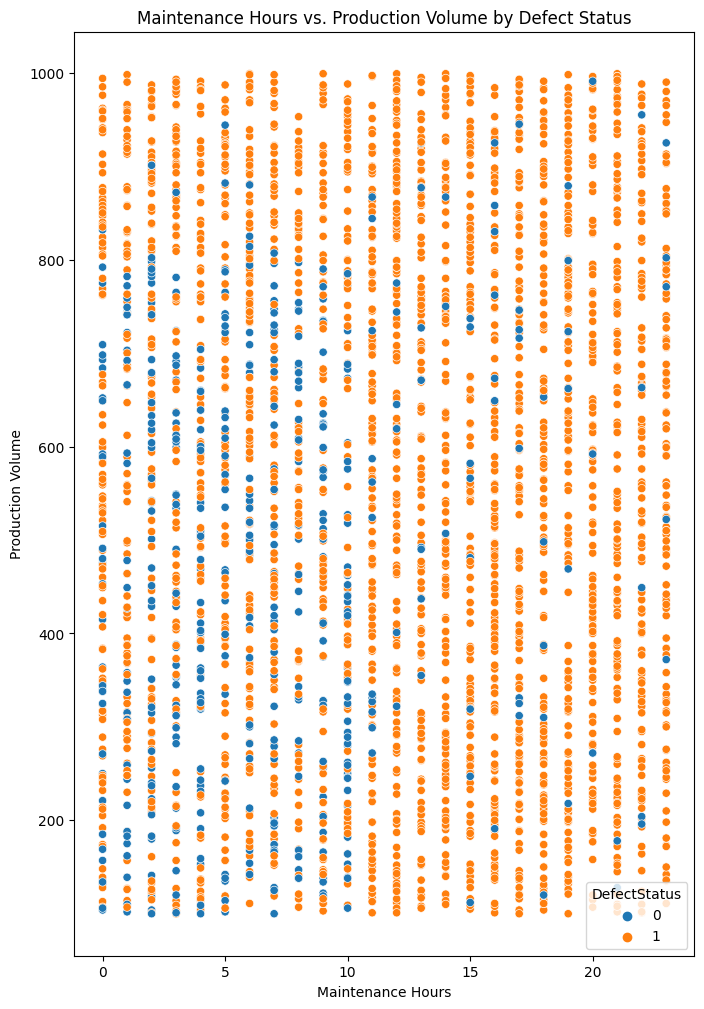

In [371]:
plt.figure(figsize=(8, 12))
sns.scatterplot(x='MaintenanceHours', y='ProductionVolume', data=df, hue='DefectStatus')
plt.title('Maintenance Hours vs. Production Volume by Defect Status')
plt.xlabel('Maintenance Hours')
plt.ylabel('Production Volume')
plt.show()

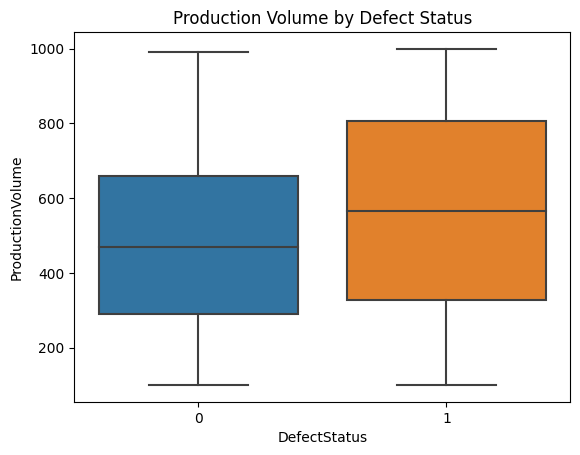

In [372]:
sns.boxplot(x='DefectStatus', y='ProductionVolume', data=df)
plt.title('Production Volume by Defect Status')
plt.show()

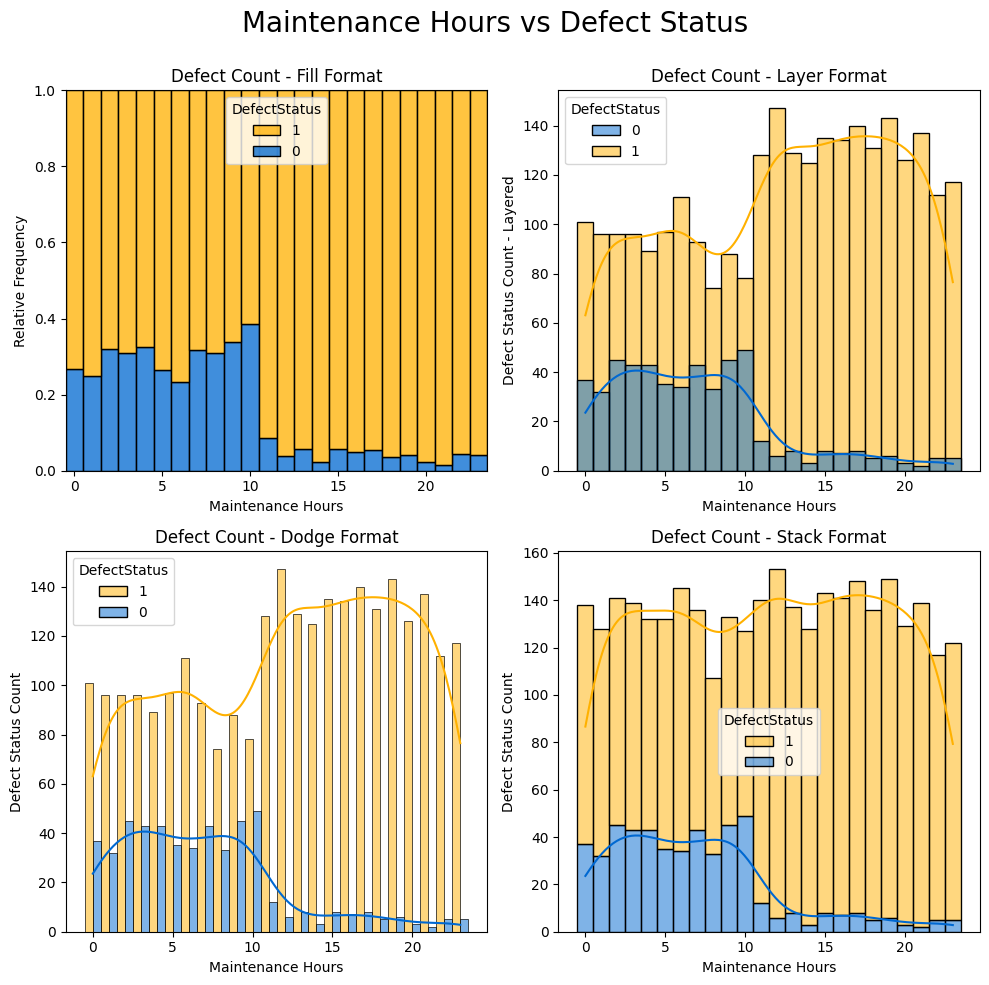

In [383]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Define chart types and chart specific params
chartTypes = {
    'fill': {
        'kernalDensity': False,
        'yLabel': 'Relative Frequency'
    },
    'layer': {
        'hueOrder': [0,1],
        'palette': ['#0068D1', '#FFB100'],
        'yLabel': 'Defect Status Count - Layered'
    },
    'dodge': {
    },
    'stack': {
    },
}

# Build Charts
for chartType, ax in zip(chartTypes.items(), axes.flat):
    multipleType = chartType[0]
    chartParams = chartType[1]
    sns.histplot(
        data=df, 
        x="MaintenanceHours", 
        hue="DefectStatus", 
        hue_order=chartParams.get('hueOrder', [1,0]), 
        multiple=chartType[0],
        kde=chartParams.get('kernalDensity', True), 
        discrete=True,
        palette=chartParams.get('palette', ['#FFB100', '#0068D1']),
        ax=ax)
    ax.set_xlabel('Maintenance Hours')
    ax.set_ylabel(chartParams.get('yLabel', 'Defect Status Count'))
    ax.set_title(chartParams.get('title', f'Defect Count - {multipleType.capitalize()} Format'))

# Display 
plt.suptitle('Maintenance Hours vs Defect Status', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

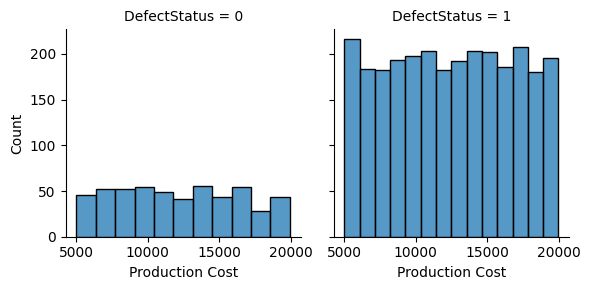

In [374]:
g = sns.FacetGrid(df, col='DefectStatus')
g.map(sns.histplot, 'ProductionCost')
g.set_axis_labels('Production Cost', 'Count')
plt.show()

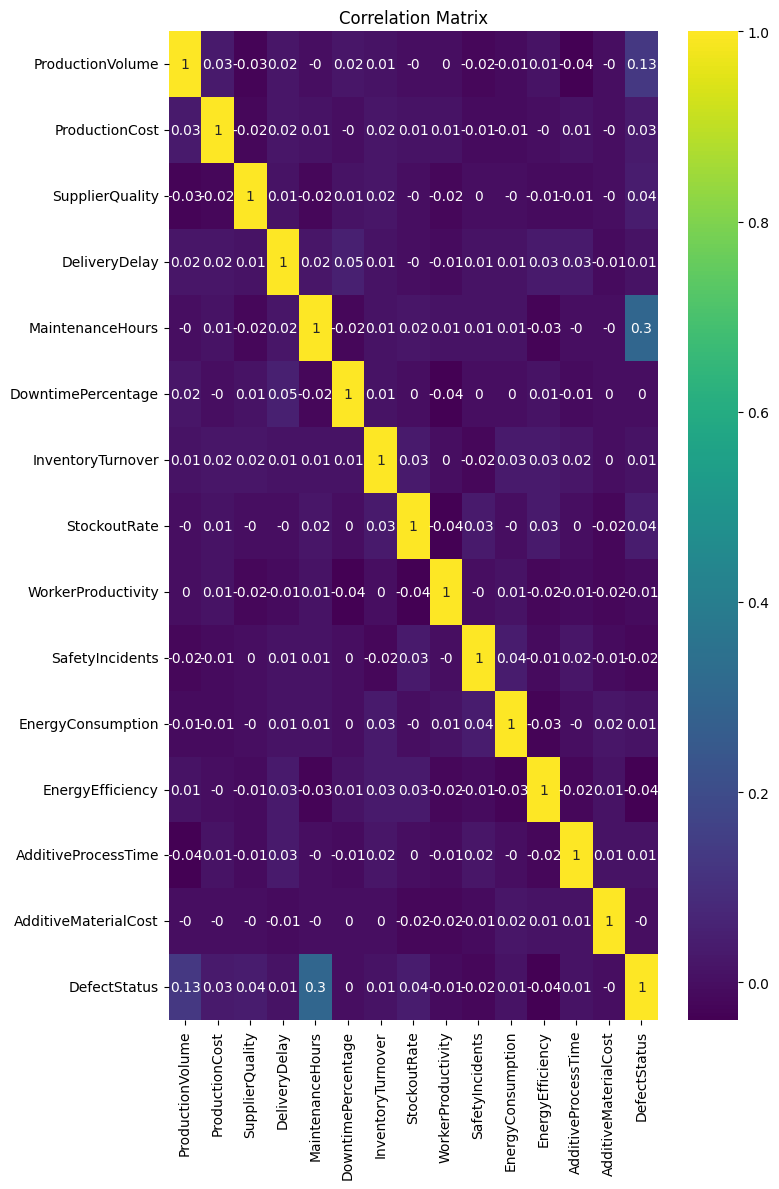

In [375]:
plt.figure(figsize=(8, 12))  # Adjust the width and height as needed
corr = df.corr()
sns.heatmap(np.round(corr, 2), annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

### Here Alex Makes some pretty charts using Seaborn

## Train Models

### Feature Engineering
Capture more complex relationships and remove features with no feature importance

In [376]:
df['MaintenanceHours_ProductionVolume_Interaction'] = df['MaintenanceHours'] * df['ProductionVolume']
# df = df.drop(['DeliveryDelay', 'SafetyIncidents'], axis=1)

### Split Data
Into Feature and Labels. 

In [377]:
# Features and label
X = df.drop([LABEL], axis=1)
y = df[LABEL]

### Create Generic Models

In [378]:
# Logistic regression classifier object
log_model = LogisticRegression()
# Create a Random Forest Classifier object
random_forest_classifer = RandomForestClassifier()
# Create a gradient boost classifier object
lgbm_model = lgb.LGBMClassifier()
# train a neural network
neural_net_results = run_neural_network(X,y)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8332 - loss: 0.4672 - val_accuracy: 0.8426 - val_loss: 0.3815
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8474 - loss: 0.3741 - val_accuracy: 0.8410 - val_loss: 0.3807
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8426 - loss: 0.3597 - val_accuracy: 0.8395 - val_loss: 0.3840
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8427 - loss: 0.3470 - val_accuracy: 0.8426 - val_loss: 0.3791
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8308 - loss: 0.3575 - val_accuracy: 0.8426 - val_loss: 0.3824
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8485 - loss: 0.3325 - val_accuracy: 0.8426 - val_loss: 0.3832
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8452 - loss: 0.3324 - val_accuracy: 0.8457 - val_loss: 0.3847
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8393 - loss: 0.3239 - val_accuracy: 0.8410 - val_loss:

In [379]:
# Run the models and get accuracy
model_results = run_model_balanced_dataset("Logistic Regression", log_model, X, y)
print(model_results)
model_results = run_model("Logistic Regression with Balanced Dataset", log_model, X, y)
print(model_results)
model_results = run_model("Random Forest", random_forest_classifer, X, y)
print(model_results)
model_results = run_model_balanced_dataset("Random Forest with Balanced Dataset", random_forest_classifer, X, y)
print(model_results)
model_results = run_model("Light Gradient Boost", lgbm_model, X, y)
print(model_results)
model_results = run_model_balanced_dataset("Light Gradient Boost with Balanced Dataset", lgbm_model, X, y)
print(model_results)
print(f'Neural Network {neural_net_results}')

{'Logistic Regression': 0.85}
{'Logistic Regression with Balanced Dataset': 0.85}
{'Random Forest': 0.84}
{'Random Forest with Balanced Dataset': 0.84}
{'Light Gradient Boost': 0.83}
{'Light Gradient Boost with Balanced Dataset': 0.83}
Neural Network {'accuracy': 0.82}


### Tune Hyperparameters on most accurate model to produce best scoring model

In [380]:
# Logistic Regression Hyperparameter Search Grid param grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}
grid_search_log = GridSearchCV(log_model, param_grid, cv=5)
model_results = run_model_balanced_dataset("grid searched Log", grid_search_log, X, y)
print(model_results)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 3, 5],
    'min_samples_split': [2, 3]
}
grid_search_rfc = GridSearchCV(random_forest_classifer, param_grid, cv=3)
model_results = run_model_balanced_dataset("grid searched Log", grid_search_rfc, X, y)
print(model_results)


{'grid searched Log': 0.84}
{'grid searched Log': 0.84}


## Best Model
Our best model is the base Logistic Regression Classifier. It is the simplest model, thus it will generalize well and scores tied for the highest at 85% accuracy.

## Make Predictions

In [382]:
test_data = {
    'ProductionVolume': 850,
    'ProductionCost': 12500,
    'SupplierQuality': 95,
    'DeliveryDelay': 2,
    'MaintenanceHours': 18,
    'DowntimePercentage': 2.5,
    'InventoryTurnover': 4.5,
    'StockoutRate': 3,
    'WorkerProductivity': 90,
    'SafetyIncidents': 2,
    'EnergyConsumption': 3500,
    'EnergyEfficiency': .25,
    'AdditiveProcessTime': 6,
    'AdditiveMaterialCost': 250
}

# Create a DataFrame from the new data
test_df = pd.DataFrame(test_data, index=[0])
test_df['MaintenanceHours_ProductionVolume_Interaction'] = df['MaintenanceHours'] * df['ProductionVolume']

# Make a prediction
prediction = log_model.predict(test_df)

print("Predicted Defect Status:", prediction[0])

Predicted Defect Status: 1


## Usefulness of this model
Users can tweak values to get the desired result - a defect status of 0. This prescriptive technique can allow operators, managers, etc. to discover what changes need to be implemented in order to minimize defects in production, with no risk to production while they run these tests

## Sharing w/ Client

### Files
- Can be downloaded/exported/emailed in any of the file formats listed under "file"

### Hosting
- AWS
- Azure
- Google Colab